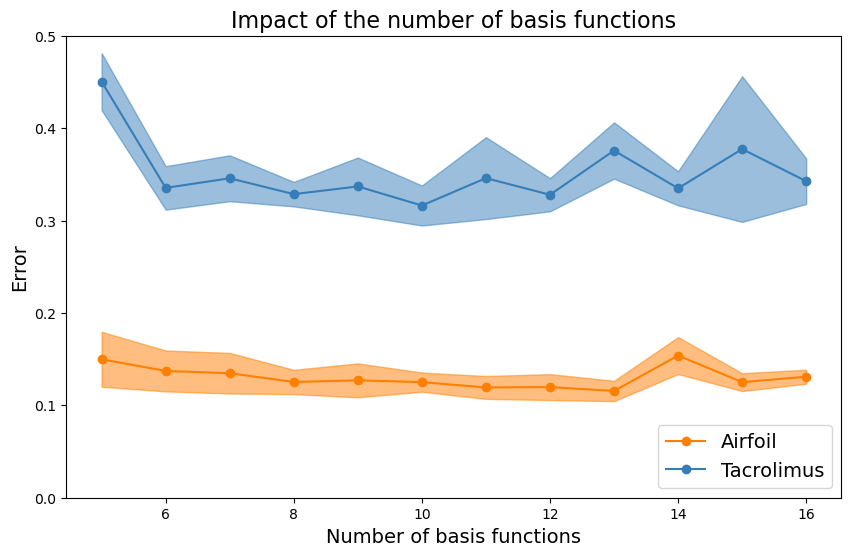

In [4]:
# This script is used to create Figure 6 in the paper
# It requires running Figure_6.sh to generate the results

import sys
sys.path.append('../../')
import pandas as pd
import matplotlib.pyplot as plt
from experiments.analysis.analysis_utils import find_results, load_result_from_timestamp

from experiments.benchmark import create_benchmark_datasets_if_not_exist

model_name = "TTS"

create_benchmark_datasets_if_not_exist(dataset_description_path="../dataset_descriptions")

def get_timestamps(dataset_name, model_name):
    timestamps = []
    for n_basis in range(5, 17, 1):
        results = find_results(dataset_name, model_name, filter_dict={"notes": f"n_basis={n_basis},rnn_type=lstm"})
        if len(results) == 0:
            print(f"No results found for {dataset_name} and {model_name} with n_basis={n_basis}")
            print("Make sure you run your experiments from ../run_scripts")
            continue
        elif len(results) > 1:
            print("Multiple results found for the given dataset and model")
            print("We take the last one but it may produce unexpected results")
        timestamps.append(results[-1])
    return timestamps

def create_df_from_timestamps(timestamps):
    n_basis = []
    methods = []
    datasets = []
    error_means = []
    error_stds = []
    time_elapsed = []

    for timestamp in timestamps:
        result = load_result_from_timestamp(timestamp)
        for method, method_results in result['results'].items():
            if method != 'TTS':
                continue
            methods.append(method)
            datasets.append(result['dataset_name'])
            error_means.append(method_results['mean'])
            error_stds.append(method_results['std'])
            time_elapsed.append(method_results['time_elapsed'])
            n_basis.append(int(result['notes'].split(",")[0].split("=")[1]))

    return pd.DataFrame({'method':methods, 'dataset':datasets, 'error_mean':error_means, 'error_std':error_stds, 'time_elapsed':time_elapsed, 'n_basis':n_basis})


dataset_name = "airfoil_log"
timestamps = get_timestamps(dataset_name, model_name)
df = create_df_from_timestamps(timestamps)

# Change this to true only if you have the tacrolimus dataset as reported in the paper
include_tacrolimus = False

if include_tacrolimus:
    dataset_name = "tacrolimus_visit_12"
    timestamps = get_timestamps(dataset_name, model_name)
    df2 = create_df_from_timestamps(timestamps)

# df = df[['method','dataset','error_mean','error_std']]
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
            '#f781bf', '#a65628', '#984ea3',
            '#999999', '#e41a1c', '#dede00']

x = list(range(5,17,1))

# Create the plot
plt.figure(figsize=(10, 6))

plt.title("Impact of the number of basis functions", fontsize=16)
plt.xlabel("Number of basis functions", fontsize=14)
plt.ylabel("Error", fontsize=14)

plt.plot(x, df['error_mean'], 'o-', color=CB_color_cycle[1], label='Airfoil')


if include_tacrolimus:
    plt.plot(x, df2['error_mean'], 'o-', color=CB_color_cycle[0], label='Tacrolimus')
    

# Add semi-transparent band
plt.fill_between(x, [v - s for v, s in zip(df['error_mean'], df['error_std'])], 
                    [v + s for v, s in zip(df['error_mean'], df['error_std'])], color=CB_color_cycle[1], alpha=0.5)

if include_tacrolimus:
    plt.fill_between(x, [v - s for v, s in zip(df2['error_mean'], df2['error_std'])], 
                        [v + s for v, s in zip(df2['error_mean'], df2['error_std'])], color=CB_color_cycle[0], alpha=0.5)

# Add title and labels
plt.ylim(0,0.5)
plt.legend(loc='lower right', fontsize=14)

# plt.savefig('figures/Figure_6.pdf', bbox_inches='tight')